In [1]:
from get_datasets.Get_Datasets import get_data_array, get_datasets
from src.Train_Model import train_model
from src.Create_Model import create_model
from src.Evolutionary_Algorithm import create_next_population, create_first_population, select_best_2_model, start_evolution

import re
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#  tf.config.experimental.set_memory_growth(physical_devices[0], True)
#except:
  # Invalid device or cannot modify virtual devices once initialized.

#  pass

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
image_size = 256
batch_size = 64
auto = tf.data.AUTOTUNE
resize_bigger = 280
num_classes = 5


def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (resize_bigger, resize_bigger))
            image = tf.image.random_crop(image, (image_size, image_size, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (image_size, image_size))
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    return _pp


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=auto)
    return dataset.batch(batch_size).prefetch(auto)

In [5]:
train_dataset, val_dataset = tfds.load("tf_flowers", split=["train[:90%]", "train[90%:]"],
                                       download=False, as_supervised=True)

num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

Number of training examples: 3303
Number of validation examples: 367


In [4]:
population_array, max_fitness_history, average_fitness_history, a, b = start_evolution(train_ds=train_dataset, val_ds=val_dataset, test_ds=val_dataset, generations=10, population=10, num_classes=5, epochs=20)

Generations:  0
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_28 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_1036 (Conv2D)        (None, 128, 128, 16)      208       
                                                                 
 batch_normalization_571 (Ba  (None, 128, 128, 16)     64        
 tchNormalization)                                               
                                                                 
 tf.nn.silu_728 (TFOpLambda)  (None, 128, 128, 16)     0         
                                                                 
 tf.math.minimum_625 (TFOpLa  (None, 128, 128, 16)     0         
 mbda)                                    

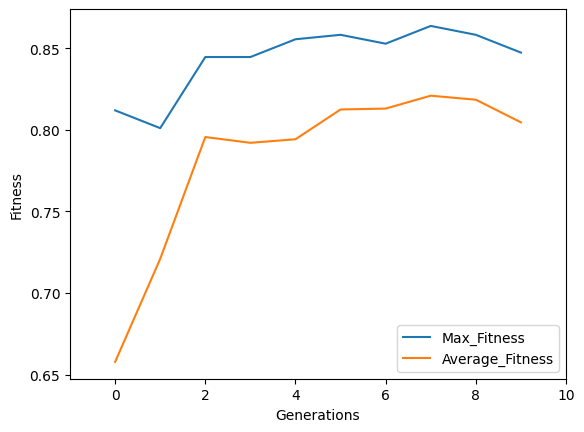

In [18]:
from matplotlib import pyplot as plt
plt.plot(max_fitness_history, label='Max_Fitness')
plt.plot(average_fitness_history,  label='Average_Fitness')
plt.ylabel('Fitness')
plt.xlabel('Generations')
plt.xlim(-1,10)
plt.legend()
plt.show()